# Text Classification - Lab

## Introduction

In this lab, we'll use everything we've learned so far to build a model that can classify a text document as one of many possible classes!

## Objectives

You will be able to:

* Generate and select appropriate features from a corpus for text classification using NLTK
* Preprocess, tokenize, and vectorize a dataset using professional tools such as NLTK and scikit-learn
* Demonstrate a working knowledge of best practices for preprocessing a dataset for text classification.


# Getting Started

For this lab, we'll be working with the classic **_Newsgroups Dataset_**, which is available as a training data set inside of `sklearn.datasets`. This dataset contains many different articles that fall into 1 of 20 possible classes. Our goal will be to build a classifier that can accurately predict the class of an article based on the features we create from the article itself!

Let's get started. Run the cell below to import everything we'll need for this lab. 

In [5]:
import nltk
from nltk.corpus import stopwords
import string
from nltk import word_tokenize, FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_20newsgroups
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
import pandas as pd
import numpy as np
np.random.seed(0)

/opt/conda/envs/learn-env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/opt/conda/envs/learn-env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/opt/conda/envs/learn-env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)


Now, we need to fetch our dataset. Run the cell below to download all the newsgroups articles and their corresponding labels. If this is the first time working with this dataset, scikit-learn will need to download all of the articles from an external repository--the cell below may take a little while to run. 

The actual dataset is quite large. To save us from extremely long runtimes, we'll work with only a subset of the classes. Here is a list of all the possible classes:

<img src='classes.png'>

For this lab, we'll only work with the following 5:

* `'alt.atheism'`
* `'comp.windows.x'`
* `'rec.sport.hockey'`
* `'sci.crypt'`
* `'talk.politics.guns'`

In the cell below:

* Create a list called `categories` that contains the 5 newsgroups classes listed above, as strings.
* Get the training set by calling `fetch_20newsgroups()` and passing in the following parameters:
    * `subset='train'`
    * `categories=categories`
    * `remove=('headers', 'footers', 'quotes')`--this is so that the model can't overfit to metadata included in the articles that sometimes acts as a dead-giveaway as to what class the article belongs to. 
* Get the testing set as well by passing in the same parameters, with the exception of `subset='test` 

In [6]:
categories = ['alt.atheism',
              'comp.windows.x',
              'rec.sport.hockey',
              'sci.crypt',
              'talk.politics.guns',]

newsgroups_train = fetch_20newsgroups(subset='train',
                                      categories=categories,
                                      remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test',
                                      categories=categories,
                                      remove=('headers', 'footers', 'quotes'))

Great! Now that we have our data, let's break apart the data and the labels, and then inspect the class names to see what the actual newsgroups are.

In the cell below:

* Grab the data from `newsgroups_train.data` and store it in the appropriate variable. 
* Grab the labels from `newsgroups_train.target` and store it in the appropriate variable. 
* Grab the label names from `newsgroups_train.target_names` and store it in the appropriate variable. 
* Display the `label_names` so that we can see the different classes of articles that we're working with, and confirm that we grabbed the right ones. 

In [65]:
data = newsgroups_train.data
target = newsgroups_train.target
label_names = np.asarray(newsgroups_train.target_names)

In [8]:
label_names

['alt.atheism',
 'comp.windows.x',
 'rec.sport.hockey',
 'sci.crypt',
 'talk.politics.guns']

Finally, let's check the shape of `data` to see what our data looks like. We can do this by checking the `.shape` attribute of `newsgroups_train.filenames`.

Do this now in the cell below.

In [9]:
newsgroups_train.filenames.shape

(2814,)

Our dataset contains 2,814 different articles spread across the 5 classes we chose. 

### Cleaning and Preprocessing Our Data

Now that we have our data, the fun part begins. We'll need to begin by preprocessing and cleaning our text data. As you've seen throughout this section, preprocessing text data is a bit more challenging that working with more traditional data types because there's no clear-cut answer for exactly what sort of preprocessing and cleaning we need to do. When working with traditional datasets, our goals are generally pretty clear for this stage--normalize and clean our numerical data, convert categorical data to a numeric format, check for and deal with multicollinearity, etc. The steps we take are largely dependent on what the data already looks like when we get a hold of it. Text data is different--if we inspect our dataset, we'll see that it has 1 dimension--the only existing feature in our dataset right now is one that contains all of the actual articles. This means that we need to make some decisions about how to preprocess our data. Before we can begin cleaning and preprocessing our text data, we need to make some decisions about things such as:

* Do we remove stop words, or not?
* Do we stem or lemmatize our text data, or leave the words as is?
* Is basic tokenization enough, or do we need to support special edge cases through the use of regex?
* Do we use the entire vocabulary, or just limit the model to a subset of the most frequently used words? If so, how many?
* Do we engineer other features, such as bigrams, or POS tags, or Mutual Information Scores?
* What sort of vectorization should we use in our model? Boolean Vectorization? Count Vectorization? TF-IDF? More advanced vectorization strategies such as Word2Vec?


These are all questions that we'll need to think about pretty much anytime we begin working with text data. 

Let's get right into it. We'll start by getting a list of all of the english stopwords, and concatenating them with a list of all the punctuation. 

In the cell below:

* Get all the english stopwords from nltk.
* Get all of the punctuation from `string.punctuation`, and convert it to a list.
* Add the two lists together. Name the result `stopwords_list`.
* Create another list containing various types of empty strings and ellipses, such as `["''", '""', '...', '``']`. Add this to our `stopwords_list`, so that we won't have tokens that are only empty quotes and such. 

In [10]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /home/gentle-
[nltk_data]     sailor-8400/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [11]:
stopwords_list = stopwords.words("english")
stopwords_list += string.punctuation
stopwords_list += ["''", '""', '...', '``']

Great! We'll leave these alone for now, until we're ready to remove stop words after the tokenization step. 

Next, let's try tokenizing our dataset. In order to save ourselves some time, we'll write a function to clean our dataset, and then use python's built-in `map` function to clean every article in the dataset at the same time. 

In the cell below, complete the `process_article()` function. This function should:

* Takes in one parameter, `article`
* Tokenize the article using the appropriate function from nltk. 
* Lowercase every token, remove any stopwords found in `stopwords_list` from the tokenized article, and return the results. 

In [12]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/gentle-
[nltk_data]     sailor-8400/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [13]:
def process_article(article):
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    tokens = nltk.regexp_tokenize(article, pattern)
    #tokens = nltk.word_tokenize(article)
    tokens = [w.lower() for w in tokens]
    tokens = list(filter(lambda w: w not in stopwords_list, tokens))
    return tokens

Now that we have this function, let's go ahead and preprocess our data, and then move into exploring our dataset. 

In the cell below:

* Use python's `map()` function and pass in 2 parameters: the `data`, and the `process_article` function. Make sure to wrap the whole map statement in a `list()`.

**_Note:_** Running this cell may take a minute or two!

In [14]:
test_str = data[0]
process_article(test_str)

['note',
 'trial',
 'updates',
 'summarized',
 'reports',
 'idaho',
 'statesman',
 'local',
 'nbc',
 'affiliate',
 'television',
 'station',
 'ktvb',
 'channel',
 'randy',
 'weaver',
 'kevin',
 'harris',
 'trial',
 'update',
 'day',
 'friday',
 'april',
 'fourth',
 'day',
 'trial',
 'synopsis',
 'defense',
 'attorney',
 'gerry',
 'spence',
 'cross',
 'examined',
 'agent',
 'cooper',
 'repeated',
 'objections',
 'prosecutor',
 'ronald',
 'howen',
 'spence',
 'moved',
 'mistrial',
 'denied',
 'day',
 'marked',
 'caustic',
 'cross',
 'examination',
 'deputy',
 'marshal',
 'larry',
 'cooper',
 'defense',
 'attorney',
 'gerry',
 'spence',
 'although',
 'spence',
 'explicitly',
 'stated',
 'one',
 'angle',
 'stategy',
 'must',
 'involve',
 'destroying',
 'credibility',
 'agent',
 'cooper',
 'cooper',
 "government's",
 'eyewitness',
 'death',
 'agent',
 'degan',
 'spence',
 'attacked',
 "cooper's",
 'credibility',
 'pointing',
 'discrepancies',
 "cooper's",
 'statements',
 'last',
 'september

In [15]:
processed_data = list(map(process_article,data))

Great. Now, let's inspect the first article inside of `processed_data` to see how it looks. 

Do this now in the cell below.

Now, let's move onto exploring the dataset a bit more. Let's start by getting the total vocabulary size of the training dataset. We can do this by creating a `set` object and then using it's `.update()` method to iteratively add each article. Since it's a set, it will only contain unique words, with no duplicates. 

In the cell below:

* Create a `set` object called `total_vocab`.
* Iterate through each tokenized article in `processed_data` and add it to the set using the set's `.update()` method.
* Once all articles have been added, get the total number of unique words in our training set by taking the length of the set.

In [16]:
total_vocab = set()
for article in processed_data:
    total_vocab.update(article)
len(total_vocab)

30697

### Exploring Data With Frequency Distributions

Great--our processed dataset contains 47,166 unique words! 

Next, let's create a Frequency Distribution to see which words are used the most! 

In order to do this, we'll need to concatenate every article into a single list, and then pass this list into a `FreqDist()` object. 

In the cell below:

* Create an empty list called `articles_concat`
* Iterate through `processed_data` and add every article it contains to `articles_concat`
* Create a `FreqDist` object and pass in `articles_concat` as the input. 
* Display the top 200 most used words. 

In [17]:
articles_concat = []
for art in processed_data:
    articles_concat += art

In [18]:
articles_freqdist = FreqDist(articles_concat)
articles_freqdist.most_common(200)

[('x', 6062),
 ('would', 1852),
 ('one', 1804),
 ('people', 1220),
 ('use', 1157),
 ('r', 1124),
 ('get', 1105),
 ('b', 1084),
 ('like', 1067),
 ('file', 1047),
 ('key', 1032),
 ('c', 1017),
 ('n', 1005),
 ('also', 880),
 ('time', 855),
 ('e', 832),
 ('know', 825),
 ('think', 820),
 ('edu', 789),
 ('could', 771),
 ('well', 738),
 ('may', 736),
 ('new', 728),
 ('even', 712),
 ('first', 697),
 ('system', 688),
 ('two', 660),
 ('information', 653),
 ('right', 651),
 ('make', 649),
 ('many', 640),
 ('see', 639),
 ('gun', 622),
 ('good', 620),
 ('p', 607),
 ('used', 605),
 ('way', 597),
 ('window', 592),
 ("i'm", 586),
 ('u', 584),
 ('government', 582),
 ('available', 574),
 ('program', 556),
 ('k', 555),
 ('db', 555),
 ('com', 548),
 ('encryption', 546),
 ('much', 546),
 ('law', 542),
 ('us', 535),
 ('using', 528),
 ('number', 528),
 ('say', 526),
 ('g', 515),
 ('must', 486),
 ('public', 480),
 ('team', 475),
 ('z', 464),
 ('game', 454),
 ('server', 451),
 ('year', 451),
 ('since', 449),
 

At first glance, none of these words seem very informative--for most of the words represented here, it would be tough to guess if a given word is used equally among all 5 classes, or is disproportionately represented among a single class. This makes sense, because this frequency distribution  represents all the classes combined. This tells us that these words probably the least important, as they are most likely words that are used across multiple classes, thereby providing our model with little actual signal as to what class they belong to. This tells us that we probably want to focus on words that appear heavily in articles from a given class, but rarely appear in articles from other classes. You may recall from previous sections that this is exactly where **_TF-IDF Vectorization_** really shines!

### Vectorizing with TF-IDF

Although NLTK does provide functionality for vectorizing text documents with TF-IDF, we'll make use of scikit-learn's TF-IDF vectorizer, because we already have experience with it, and because it's a bit easier to use, especially when the models we'll be feeding the vectorized data into are from scikit-learn, meaning that we don't have to worry about doing any extra processing to ensure they play nicely together. 

Recall that in order to use scikit-learn's `TfidfVectorizer`, we need to pass in the data as raw text documents--the `TfidfVectorizer` handles the Count Vectorization process on it's own, and then fits and transforms the data into TF-IDF format. 

This means that we need to:

* Import `TfidfVectorizer` from `sklearn.feature_extraction.text` and instantiate a `TfidfVectorizer` object
* Call the vectorizer object's `fit_transform()` method and pass in our `data` as input. Store the results in `tf_idf_data_train`.
* Also create a vectorized version of our testing data, which can be found in `newsgroups_test.data`. Store the results in `tf_idf_data_test`. 


**_NOTE:_** When transforming the test data, use the `.transform()` method, not the `.fit_transform()` method, as the vectorizer has already been fit to the training data. 

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [37]:
vectorizer = TfidfVectorizer()

In [38]:
tf_idf_data_train = vectorizer.fit_transform(data)

In [39]:
tf_idf_data_test = vectorizer.transform(newsgroups_test.data)

### Modeling Our Data

Great! We've now preprocessed and explored our dataset, let's take a second to see what our data looks like in vectorized form. 

In the cell below, get the shape of `tf_idf_data`.

In [40]:
tf_idf_data_train.shape

(2814, 36622)

Our vectorized data contains 2,814 articles, with 36,622 unique words in the vocabulary. However, the vast majority of these columns for any given article will be zero, since every article only contains a small subset of the total vocabulary. Recall that vectors mostly filled with zeros are referred to as **_Sparse Vectors_**. These are extremely common when working with text data. 

Let's check out the average number of non-zero columns in the vectors. Run the cell below to calculate this average. 

In [41]:
non_zero_cols = tf_idf_data_train.nnz / float(tf_idf_data_train.shape[0])
print("Average Number of Non-Zero Elements in Vectorized Articles: {}".format(non_zero_cols))

percent_sparse = 1 - (non_zero_cols / float(tf_idf_data_train.shape[1]))
print('Percentage of columns containing 0: {}'.format(percent_sparse))

Average Number of Non-Zero Elements in Vectorized Articles: 107.28038379530916
Percentage of columns containing 0: 0.9970706028126451


As we can see from the output above, the average vectorized article contains 107 non-zero columns. This means that 99.7% of each vector is actually zeroes! This is one reason why it's best not to create your own vectorizers, and rely on professional packages such as scikit-learn and NLTK instead--they contain many speed and memory optimizations specifically for dealing with sparse vectors. This way, we aren't wasting a giant chunk of memory on a vectorized dataset that only has valid information in 0.3% of it. 

Now that we've vectorized our dataset, let's create some models and fit them to our vectorized training data. 

In the cell below:

* Create a `MultinomialNB` and `RandomForestClassifier`. For the Random Forest, set `n_estimators` to `100`. Don't worry about tweaking any of the other parameters. 
* Fit each to our vectorized training data.
* Create predictions for our training and testing sets
* Calculate the `accuracy_score` for both the training and testing sets (you'll find our training labels stored within the variable `target`, and the testing labels stored within `newsgroups_test.target`)

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

In [43]:
nb_classifier = MultinomialNB().fit(tf_idf_data_train,target)
rf_classifier = RandomForestClassifier().fit(tf_idf_data_train,target)

/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [44]:
nb_train_preds = nb_classifier.predict(tf_idf_data_train)
nb_test_preds = nb_classifier.predict(tf_idf_data_test)

In [47]:

rf_train_preds = rf_classifier.predict(tf_idf_data_train)
rf_test_preds = rf_classifier.predict(tf_idf_data_test)

In [48]:
nb_train_score = accuracy_score(nb_train_preds, target)
nb_test_score = accuracy_score(nb_test_preds, newsgroups_test.target)
rf_train_score = accuracy_score(rf_train_preds, target)
rf_test_score = accuracy_score(rf_test_preds, newsgroups_test.target)

print("Multinomial Naive Bayes")
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(nb_train_score, nb_test_score))
print("")
print('-'*70)
print("")
print('Random Forest')
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(rf_train_score, rf_test_score))

Multinomial Naive Bayes
Training Accuracy: 0.9531 		 Testing Accuracy: 0.8126

----------------------------------------------------------------------

Random Forest
Training Accuracy: 0.9794 		 Testing Accuracy: 0.6866


In [52]:
import sklearn

In [59]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


Confusion matrix, without normalization
[[169   7  19  85  39]
 [  0 348   7  38   2]
 [  0   1 376  15   7]
 [  0  10  20 352  14]
 [  6   1  18  62 277]]


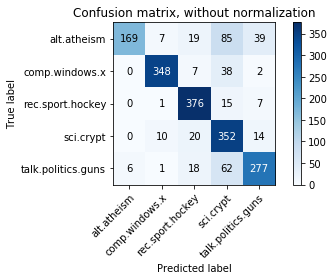

In [67]:
plot_confusion_matrix(newsgroups_test.target,nb_test_preds,classes = label_names);

In [ ]:
sklearn.metrics.confusion_matrix(nb_test_preds, newsgroups_test.target)

### Interpreting Results

**_Question:_** Interpret the results seen above. How well did the models do? How do they compare to random guessing? How would you describe the quality of the model fit?

Write your answer below this line:
_______________________________________________________________________________________________________________________________



# Summary

In this lab, we used our NLP skills to clean, preprocess, explore, and fit models to text data for classification. This wasn't easy--great job!!